In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import CBB_Funcs as cbb_fun
import pickle
from playsound import playsound
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Get team names and urls
teams_source = pd.read_excel('Team_Source.xlsx', header=None, names=['2016', '2016_Teams', '2016 Conf', '2017', '2017_Teams', '2018', '2018_Teams',
                                                                     '2019', '2019_Teams', '2020', '2020_Teams', '2021', '2021_Teams'])
# select years to be processed
years = ['2016', '2017', '2018', '2019']
#years = ['2021']

# Set data-gathering parameters
load = True
scrape_data = True

# Initialize dataframe
cbb_df = pd.DataFrame()

# loop through each year to be looked at
for yr in years:
    if load:
        sources, teams, team_dict = cbb_fun.get_logistics(teams_source, yr) # #urls and team names for that year
        #combined_df = [pd.read_csv('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.csv') for ii in range(len(teams))] # load pre-processing data into list of dataframes   
#         with open('./Team_Dataframes/' + yr + '/Combined.pickle', 'rb') as f:
#             combined_df = pickle.load(f)
        combined_df = []
        for ii in range(len(teams)):
            with open('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.pickle', 'rb') as f:
                combined_df.append(pickle.load(f))
        
        cbb_df = pd.concat((cbb_df, pd.concat(combined_df))) # concatenate all dataframes to final output dataframe
    else:
        teams_df, teams, team_dict = cbb_fun.get_team_data(teams_source, yr, scrape_data=scrape_data) # grab data for each team during the 'yr'
        combined_df, next_g = cbb_fun.combine_data(teams_df, team_dict, teams, year=yr) # process the data adding information about opponent and previous games
        cbb_df = pd.concat((cbb_df, pd.concat((combined_df)))) # concatenate all dataframes to final output dataframe

# if loading all years, save to final '.csv' file
# not necesasry for model development
if len(years) == 4:
    cbb_df.to_csv('./Final_Dataframes/Teams_Combined.csv', index=False)

print('DONE LOADING ALL DATA')
playsound('mixkit-intro-transition-1146.wav')

DONE LOADING ALL DATA


NameError: name 'playsound' is not defined

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold

features = ['Avg_Result', 'Avg_Result2', 'Avg_Result_NC', 'Avg_Result_NC2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS',
            'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Home_Pct', 'Home_Pct2', 'Scoring_Pace_Diff']

num_features = len(features)

#data = cbb_df.dropna(subset=features)
data = cbb_df[cbb_df['Game_Number'] > 9].dropna(subset=features)

X = data[features]
y = np.array(data['result'])

scx = StandardScaler()
scy = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y)


Xsc = scx.fit_transform(X_train)
ysc = scy.fit_transform(y_train.reshape(len(y_train), 1))


## try autoregressive RNN model
i = Input(shape = (num_features, 1))
x = LSTM(5)(i)
x = Dense(2)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.001),
)

# train the RNN
r = model.fit(
    Xsc, ysc,
    epochs = 20,
    validation_data = (scx.transform(X_test), scy.transform(y_test.reshape(len(y_test), 1))),
) # 147

Epoch 1/20
744/744 [==============================] - 6s 7ms/step - loss: 1.0001 - val_loss: 0.9560
Epoch 2/20
744/744 [==============================] - 5s 7ms/step - loss: 0.9981 - val_loss: 0.9540
Epoch 3/20
744/744 [==============================] - 5s 7ms/step - loss: 0.9951 - val_loss: 0.9474
Epoch 4/20
744/744 [==============================] - 5s 7ms/step - loss: 0.9401 - val_loss: 0.8624
Epoch 5/20
744/744 [==============================] - 5s 7ms/step - loss: 0.8836 - val_loss: 0.8306
Epoch 6/20
744/744 [==============================] - 5s 7ms/step - loss: 0.7957 - val_loss: 0.7158
Epoch 7/20
744/744 [==============================] - 5s 7ms/step - loss: 0.7388 - val_loss: 0.6898
Epoch 8/20
744/744 [==============================] - 5s 7ms/step - loss: 0.7205 - val_loss: 0.6757
Epoch 9/20
744/744 [==============================] - 5s 7ms/step - loss: 0.7022 - val_loss: 0.6970
Epoch 10/20
744/744 [==============================] - 5s 6ms/step - loss: 0.6956 - val_loss: 0.6717

In [33]:
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
# preds = scx.inverse_transform(model.predict(scx.transform(X_test)))
# mean_squared_error(y_test, preds)
a = [[ 2.06850771,  0.3177479 ,  1.45136205,  0.70824758, -0.9201095 ,
        1.10973191, -0.25160416, -0.2157574 ,  0.74924119,  0.07368955,
        0.32795591, -0.27213971, -1.01182599, -1.06641661,  1.95400245,
        0.34674887,  0.21189576, -0.81423816,  1.54092282]]
model.predict(a)

array([[0.97995186, 0.96482104]], dtype=float32)

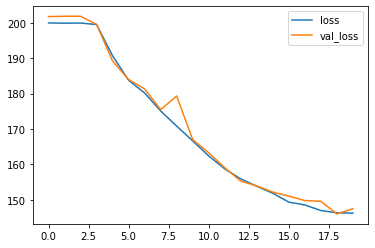

In [14]:
# Plot the loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend();

In [4]:
class Dataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)

In [5]:
# Now let's build the above network
class Model(nn.Module):
    def __init__(self, input_features, output_features):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_features, 5)
        self.fc2 = nn.Linear(5,4)
        self.fc3 = nn.Linear(4,3)
        self.fc4 = nn.Linear(3,output_features)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        out = self.sigmoid(out)

        return out
        

In [15]:
features = ['Avg_Result', 'Avg_Result2', 'Avg_Result_NC', 'Avg_Result_NC2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS',
            'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Home_Pct', 'Home_Pct2', 'Scoring_Pace_Diff']

num_features = len(features)

#data = cbb_df.dropna(subset=features)
data = cbb_df[cbb_df['Game_Number'] > 9].dropna(subset=features)

X = data[features]
y = data['Win']

# Feature Normalization. All features should have the same range of values
sc = StandardScaler()
X = sc.fit_transform(X)

# Now we convert the arrays to PyTorch tensors
X = torch.tensor(X)
y = torch.tensor(list(y)).unsqueeze(1)

dataset = Dataset(X,y)

# Load the data to your dataloader for both processing and shuffling
train_loader = torch.utils.data.DataLoader(dataset = dataset, 
                           batch_size = 32,
                           shuffle = True)

#Create the network (an object of the Net class)
net = Model(num_features,1)
#In Binary Cross Entropy: the inpout and output should have the same shape
#size_average = True --> the losses are averaged over observations for each minibatch
criterion = torch.nn.BCELoss(size_average = True)
#criterion = torch.nn.MSELoss()
#We will use SGD with momentum with a learning rate of 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

# Training the Network
epochs = 1
accuracy = np.zeros((epochs,1))
mse = []

for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.float()
        # Forward Propagation
        outputs = net(inputs)
        #Loss Calculation
        loss = criterion(outputs, labels)
        #print(Loss)
        #Clear the gradient buffer (w <-- w - lr*gradient)
        optimizer.zero_grad()
        #Backprop
        loss.backward()
        #Update Weights
        optimizer.step()
        
    # Accuracy Calculation
    output = (outputs>0.5).float()
    # (output == labels).sum() / output.shape
    accuracy[epoch, 0] = (output == labels).float().mean()
    
    # Accuracy Calculation
    mse.append((output == labels).float().mean())
    
    #Print Statistis
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy:   {:.3f}".format(epoch+1, epochs, loss, accuracy[epoch,0]))
 
plt.plot(list(range(epochs)), mse);

TypeError: object.__new__() takes exactly one argument (the type to instantiate)

In [39]:
features = ['Avg_Result', 'Avg_Result2', 'Avg_Result_NC', 'Avg_Result_NC2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS',
            'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Home_Pct', 'Home_Pct2', 'Scoring_Pace_Diff']

num_features = len(features)

#data = cbb_df.dropna(subset=features)
data = cbb_df[cbb_df['Game_Number'] > 9].dropna(subset=features)

X = data[features]
y = np.array(data['result'])

# Feature Normalization. All features should have the same range of values
scx = StandardScaler()
scy = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_sc = scx.fit_transform(X_train)
y_sc = scy.fit_transform(y_train.reshape(len(y_train), 1))

# # Try a linear model first - note: it is classification now!
# i = Input(shape=(num_features,2))
# x = Dense(2, activation = 'sigmoid')(i)
# model = Model(i,x)
# model.compile(
#     loss = 'binary_crossentropy',
#     optimizer = Adam(lr=0.01),
#     metrics = ['accuracy'],
# )

model = tf.keras.Sequential([
    Flatten(input_shape=(num_features,)),
    Dense(2096),
    Dense(24),
    Dense(1)
])

model.compile(optimizer=Adam(lr=0.0000005), loss='mse')

# train the network
r = model.fit(
    X_sc, y_sc,
    epochs=100,
    validation_data = (scx.transform(X_test), scy.transform(y_test.reshape(len(y_test), 1))),
)

predictions = model.predict(scx.transform(X_test))
predictions = scy.inverse_transform(predictions)
mean_squared_error(y_test, predictions) # 0.5997 val-loss, 100 epochs, lr=0.0000005, mse = 121.29172069683209

Epoch 1/100
744/744 [==============================] - 2s 3ms/step - loss: 0.9117 - val_loss: 0.8099
Epoch 2/100
744/744 [==============================] - 2s 3ms/step - loss: 0.7833 - val_loss: 0.7194
Epoch 3/100
744/744 [==============================] - 2s 3ms/step - loss: 0.7106 - val_loss: 0.6697
Epoch 4/100
744/744 [==============================] - 2s 3ms/step - loss: 0.6702 - val_loss: 0.6429
Epoch 5/100
744/744 [==============================] - 2s 3ms/step - loss: 0.6486 - val_loss: 0.6291
Epoch 6/100
744/744 [==============================] - 2s 3ms/step - loss: 0.6370 - val_loss: 0.6215
Epoch 7/100
744/744 [==============================] - 2s 3ms/step - loss: 0.6303 - val_loss: 0.6170
Epoch 8/100
744/744 [==============================] - 2s 3ms/step - loss: 0.6261 - val_loss: 0.6140
Epoch 9/100
744/744 [==============================] - 2s 3ms/step - loss: 0.6233 - val_loss: 0.6118
Epoch 10/100
744/744 [==============================] - 2s 3ms/step - loss: 0.6212 - val_lo

121.29172069683209

KeyError: 'val_loss'

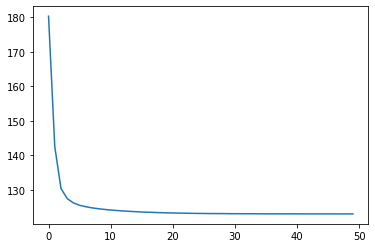

In [140]:
#Plot the loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

In [145]:
a = sc.fit_transform(X, y)
a.shape, X.shape

((31732, 12), (31732, 12))

In [134]:
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RandomForest MSE:', mse)

RandomForest MSE: 131.22192644648933


In [132]:
X.shape, y.reshape(len(y), 1).shape

((31732, 12), (31732, 1))

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
xgbmodel = XGBRegressor(n_estimators=20)
xgbmodel.fit(X_train, y_train, verbose=False)

y_pred = xgbmodel.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
print('XGBoost MSE:', mse)

XGBoost MSE: 127.08801837597234


In [163]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

def running_means(scores, opp_scores, mean_scores, threes, opp_threes, fg_pct, opp_fg_pct):
    """
        Function takes in (scores, opp_scores) which are lists of a team's scores
        and the scores of its opponents. The function returns two lists which 
        are the running means of the team and the team's previous opponents.
    """
    
    # 'means' and opp_means are initialized with a NaN value because there is no
    # previous data to grab before the first game
    means = [np.nan]
    opp_means = [np.nan]
    avg_mean_scores = [np.nan]
    avg_threes = [np.nan]
    avg_opp_threes = [np.nan]
    avg_fg_pct = [np.nan]
    avg_opp_fg_pct = [np.nan]
    
    # loops through each score and opponent score beginning with game 2
    for idx, (score, opp_score)  in enumerate(zip(scores[1:], opp_scores[1:])):
        
        # appends the running means
        means.append(scores[:idx+1].mean())
        opp_means.append(opp_scores[:idx+1].mean())
        avg_mean_scores.append(mean_scores[:idx+1].mean())
        avg_fg_pct.append(fg_pct[:idx+1].mean())
        avg_opp_fg_pct.append(opp_fg_pct[:idx+1].mean())
        
        # calculates percentage of points scored and given up by threes and then substracts the pre-calculated league average
        avg_threes.append(((threes[:idx+1]*3).mean() / means[idx+1]) - threes_pct)
        avg_opp_threes.append(((opp_threes[:idx+1]*3).mean() / opp_means[idx+1]) - threes_pct) 

    return means, opp_means, avg_mean_scores, avg_threes, avg_opp_threes, avg_fg_pct, avg_opp_fg_pct

def get_logistics(year):
    # Grabs logistical data about the college basketball teams
    sources = teams_source[year].dropna()                  # website sources for each team
    teams = teams_source[year + '_Teams'].dropna()         # names of teams 
    team_nums = list(range(len(teams))) # idx numbers for each team
    team_dict = {teams[num]: num for num in team_nums}
    
    return year, sources, teams, team_dict

def get_linear_stats(X, y, n_runs=10, n_folds=10):
    """
        Takes in X and y data and returns Linear Model statistics.
        Returns Standard Error, Standard Deviation, Mean Squared Error,
        Cross-Validation Score, and statsmodels OLS results.
        
        n_runs is the number of training runs to perform. An increase in n_runs
        provides more stable results.
        
        n_folds is the number of folds to create in the cross-validation test
    """
    
    # Initialized Linear Regression model
    lr = LinearRegression()
    
    # drops null values from data input
    X = X.dropna()
    y = y.dropna()
    
    # number for features in model
    num_features = X.shape[1]
    
    # initializes statistics that will be averaged
    MSEs = []
    SE = []
    stds = []
    scores = []
    pct_acc = []
    cv = []
    coefs = []
    
    # Number of training runs
    # Increase in runs stabilizes results
    for ii in range(n_runs):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        lr.fit_intercept = False
        lr.fit(X_train, y_train)

        y_pred = lr.predict(X_test)
        
        # Difference between predicted results and test data
        resid = y_pred - y_test
        
        # Append statistics
        SE.append(np.std(resid, ddof=num_features) / np.sqrt(np.size(resid)))
        stds.append(np.std(resid, ddof=num_features))
        MSEs.append(mean_squared_error(y_test, y_pred))
        scores.append(lr.score(X_test, y_test))
        
         # Show percent accuracy of predicting win/loss
        num_correct = 0
        for pred, act in zip(y_pred, y_test):
            if pred*act > 0:
                num_correct += 1
        pct_acc.append(num_correct/len(y_test))
        
        coefs.append(lr.coef_)
        
        cv.append(cross_val_score(LinearRegression(), X, y, cv=KFold(n_folds, shuffle=True)).mean())
   
    
    # Develop OLS model
    model = sm.OLS(y_train, X_train, missing = 'drop') # sm.add_constant(X)
    results = model.fit()
    
    return np.mean(SE), np.mean(stds), np.mean(MSEs), np.mean(cv), results, np.mean(pct_acc)*100, np.mean(coefs, axis=0)

def get_logistic_stats(X, y, n_runs=10, n_folds=10):
    """
        Takes in X and y data and returns Logistic Model statistics.
        Returns Percent Accuracy.
        
        n_runs is the number of training runs to perform. An increase in n_runs
        provides more stable results.
        
        n_folds is the number of folds to create in the cross-validation test
    """

    # drops null values from data input
    X = X.dropna()
    y = y.dropna()
    
    sc = StandardScaler()
    X = sc.fit_transform(X)

    # Initialized Logistic Regression model
    lr = LogisticRegression(max_iter=1000)
    
    # initializes statistics that will be averaged
    cv = []
    coefs = []
    
    # Number of training runs
    # Increase in runs stabilizes results
    for ii in range(n_runs):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        lr.fit(X_train, y_train)

        coefs.append(lr.coef_)
        
        cv.append(cross_val_score(LogisticRegression(max_iter=1000), X, y, cv=KFold(n_folds, shuffle=True)).mean())
    
    return np.mean(cv)*100, np.mean(coefs, axis=0)

def webscrape_data(year, sources, teams):
    dataframes = [] # list of dataframes

    # Loops through each team listed in the sources list of urls
    for ii, src in enumerate(sources):
        content = urllib.request.urlopen(src) # opens content of url
        read_content = content.read()   # reads content

        soup = BeautifulSoup(read_content,'html.parser')  # pass the content to BeautifulSoup to parse
        tags = soup.find_all('td') # grab only tags with 'td' which grabs the data table from the website

        data = []
        row = []
        # loops through extracted tag
        for idx, tr in enumerate(tags):
            row.append(tr.text) # appends text of the tag

            # Given that there are 39 columns of data in the table,
            # a check is perfromed on if the tag is the last tag
            # in the row
            if (idx + 1)%39 == 0: 

                # if the opponent team name ('idx 3'), does not an 'a' href,
                # then that team is not a Division 1 school and will not have 
                # data of its own in the dataframe. Because the program will use
                # data from the opponent, all data from non-Division 1 schools
                # is removed.
                if tags[idx - 36].find('a'):
                    data.append(row) # row of data is appended to data list if opponent is Division 1
                row = []

        # Removes cancelled game between Hampton and Morgan State
        # Score was 2-0 at the time of cancellation
        if (year == '2018') and ((ii == 112) or (ii == 191)):
            if ii == 112:
                data = data[:26] + data[27:]
            else:
                data = data[:24] + data[25:]

        # dataframe is created and key columns are renamed to better represent the data
        df = pd.DataFrame(data).rename(columns = {0: 'Date', 1: 'Loc', 2: 'Opp_name', 3: 'Win', 4: 'Score', 5: 'Opp_score', 8: 'FG_Pct', 9:'Threes', 25: 'Opp_FG_Pct', 9:'Threes', 26: 'Opp_Threes'})

        # datatypes of numerical columns are changed to floats 
        try:
            df = df.astype({key: float for key in df.keys() if key not in ['Date', 'Loc', 'Opp_name', 'Win', 22]})
        except ValueError: # handles value errors (by looking through the data it was determined there are a few instances where a cell was left blank)
            for col in df: # iterates through each column in dataframe
                float_vals = []
                for val in df[col]: # iterates through each value in column
                    try:
                        float_vals.append(float(val)) # converts to float if possible
                    except ValueError:   # used for values that cannot be converted to float
                        if col not in ['Date', 'Loc', 'Opp_name', 'Win', 22]:  # checks to make sure it wasn't supposed to be a String
                            float_vals.append(np.nan) # replace blank space with NaN
                        else:
                            float_vals.append(val) # leaves value as is

                df[col] = pd.Series(float_vals) # replaces column with new "float_values"

        # Convert 'Date' to datetime for evaluation later in runtime
        df['Date'] = pd.to_datetime(df['Date'])

        # The result column is added which represents how much the team lost or won by in that game
        # This will be the y-vector that the prediction model uses.
        df['result'] = df['Score'] - df['Opp_score']
        
        # The 'Win' column is 1 if the team won the game and 0 otherwise.
        # This will be another y-vector that the model predicts
        df['Win'] = np.where(df['result'] > 0, 1, 0)

        # Keep track of the Game Number
        df['Game_Number'] = list(range(1, len(df) + 1))

        # Calcultes the mean score of each game ( (team_score + opp_score) / 2 )
        df['Mean_Score'] = df[['Score', 'Opp_score']].mean(axis = 1)

        # Columns that represent the average scores of both the team and team's previous opponents
        # are added to the dataframe. This is done by calling the "running_means" function.
        # The data represents the averages going into the game
        df['Avg_Score'], df['Opp_Avg_Score'], df['Avg_Mean_Score'], df['Avg_Threes'], df['Opp_Avg_Threes'], df['Avg_FG_Pct'], df['Opp_Avg_FG_Pct'] = \
        running_means(df['Score'], df['Opp_score'], df['Mean_Score'], df['Threes'], df['Opp_Threes'], df['FG_Pct'], df['Opp_FG_Pct'])

        # Calculates the average value of vicotry/loss
        df['Avg_Result'] = df['Avg_Score'] - df['Opp_Avg_Score']

        # Calculates the percent margin of victory/loss as percentage of mean scores
        df['Pct_Margin'] = df['Avg_Result'] / df['Avg_Mean_Score']

        # Create Dummy Variables for Home and Away
        location = pd.get_dummies(df['Loc'])
        if location.shape[1] == 3:
            location.columns = ['Home', 'Away', 'Neutral']
        else: # needed for teams that don't have any neutral-site games
            location.columns = ['Home', 'Away']   

        # concatenate original dataframe to new location dummy dataframe
        df = pd.concat((df, location), axis = 1)

        # create a column that contains the average season result in every row
        df['Avg_Result_Fin'] = [df['Score'].mean() - df['Opp_score'].mean()] * len(df)

        # Create a column that contains just the average result from non-conference games (first 10 games)
        df['Avg_Result_NC'] = list(df['Avg_Result'][:10]) + [df['Avg_Result'][9]] * (len(df) - 10)

        # saves dataframe
        df.to_csv('./Team_Dataframes/' + year + '/Team_Only/' + teams[ii] + '.csv', index = False)

        # add dataframe to list of dataframes
        dataframes.append(df)
    
    print('DONE WITH DATA INTAKE', year)
    return dataframes

def load_frames(teams=[], year='2016', multiple=False):
    
    if multiple:
        
        dataframes = pd.read_csv('./Final_Dataframes/Teams_Only.csv')
        
        dataframes['Date'] = pd.to_datetime(dataframes['Date'])
    
    else:
        
        dataframes = [pd.read_csv('./Team_Dataframes/' + year + '/Team_Only/' + teams[ii] + '.csv') for ii in range(len(teams))]

        for df in dataframes:

            # Convert 'Date' to datetime for evaluation later in runtime
            df['Date'] = pd.to_datetime(df['Date'])
    
    print('DONE LOADING FRAMES')
    
    return dataframes

# Grabs logistical data about the college basketball teams
def get_team_data(year='2016', multiple=False, scrape_data=False):
    """
       Returns team-specific data. Default arguments (year='2016', multiple=False, scrape_data=False).
       'year' specificies which year of data to collect.
       'multiple' will return only the 'year' of data when set to False, but will return all years when set to True
       'scrape_data' will load existing data if set to False, but will scrape data from the web if set to True
    """

    if multiple:

        years = ['2016', '2017', '2018', '2019']

        ## run if scraping new data
        if scrape_data:

            tot_frame = []

            for year in years:

                # grab logistical data such as web sources and team names
                year, sources, teams, team_dict = get_logistics(year)
                dataframes = webscrape_data(year, sources, teams)
                tot_frame.append(pd.concat((dataframes)))

            tot_frame = pd.concat((tot_frame))
            tot_frame.to_csv('./Final_Dataframes/Teams_Only.csv', index=False)

        ## run if loading existing 
        else:

            tot_frame = load_frames(multiple=True)
            
        return tot_frame, '', ''

    else:

        year, sources, teams, team_dict = get_logistics(year)

        ## run if scraping new data
        if scrape_data:

            dataframes = webscrape_data(year, sources, teams)

        ## run if loading existing 
        else:

            dataframes = load_frames(teams=teams, year=year)

        return dataframes, teams, team_dict
    
def combine_data(dataframes, team_dict, teams, year='2016'):
    """
    Takes in a list of dataframes
    Function looks at team's opponents' dataframes and concatenates the team's dataframe
    with data from the opponents.
    Returns a list of concatenated dataframes for each team
    """
    
    # Initialize a list of dataframes that will combine a team's dataframe with data from its opponents
    combined_df = []

    # loop through each dataframe (team)
    for ii, df in enumerate(dataframes):

        # initialize a list that will represent the strength of schedule of the team entering the game
        # initialized with NaN because there would be no previous opponents entering the first game
        sos = [np.nan]
        sos_all = [np.nan] # uses final average result from each previous opponent
        sos_nc = [np.nan] # team's non-conference SOS

        # initialize a list that will represent the strength of schedule of the team's previous opponents
        # entering the game
        # initialized with NaN because there would be no previous opponents entering the first game
        prev_sos = [np.nan]
        prev_sos_all = [np.nan] # uses final average result from each previous opponent
        prev_sos_nc = [np.nan] # team's non-conference SOS

        # Initializes a list that will represent the strength of schedule of the opponent entering the game
        # This list is not initialized with NaN because the opponent may have already played a game before
        # the team's first game
        opp_sos =[]
        opp_sos_nc = []
        opp_prev_opp_sos = []

        # list that will contain data of opponent
        opp_data = []

        # names of all opponents
        opp_names = df['Opp_name']
        
        name_check = teams[ii]

        # loops through every game, specifically by enumerating the opponent name column
        for idx, name in enumerate(opp_names):
            
            date_check = df['Date'][idx]
            
            # will loop through each team's opponent prior to current game
            # first checks if idx is greater than 0 because there are no games
            # before the first game
            if idx > 0:
                
                # list of all previous opponents
                prev_opps = opp_names[:idx]

                # list that will store average win/loss results for each previous opponent
                avg_results = []
                sos_all_results = [] # stores the final average score for each previous opponent
                sos_nc_games = []

                # lists that will store average win/loss results for each previous opponent's previous opponents
                prev_prev_avg_results = []
                prev_sos_all_results = []
                prev_sos_nc_games = []

                # loop through each previous opponent
                for jj, prev_name in enumerate(prev_opps):
                    # previous opponent dataframe
                    prev_df = dataframes[team_dict[prev_name]]
                    
                    len_prev = len(prev_df)

                    # loops through each game for previous opponent
                    for idx3, date2 in enumerate(prev_df['Date']):
                        if date2 >= date_check:
                            prev_avg_result = prev_df['Avg_Result'][idx3]
                            prev_opp_prev = prev_df['Opp_name'][:idx3]
                            break
                        elif idx3 == (len_prev - 1):
                            prev_avg_result = prev_df['Avg_Result_Fin'][0]
                            prev_opp_prev = prev_df['Opp_name']
                            break     

                    ## Only grabs index <= 10 as that is about how many pre-conference
                    ## games each team plays
                    if jj <= 10:
                        sos_nc_games.append(prev_avg_result)

                    ## append strength of schedule data
                    avg_results.append(prev_avg_result)
                    sos_all_results.append(prev_df['Avg_Result_Fin'][0])

                    # loops through the previous opponents of the previous opponent
                    # to find the SOS of previous opponents
                    for prev_opp in prev_opp_prev:
                        prev2_df = dataframes[team_dict[prev_opp]]
                        
                        len_prev2 = len(prev2_df)

                        for kk, date_kk in enumerate(prev2_df['Date']):
                            if date_kk >= date_check:
                                #prev_prev_avg_result = prev2_df['result'][:kk].mean()
                                prev_prev_avg_result = prev2_df['Avg_Result'][kk]
                                break
                            elif kk == (len_prev2 - 1):
                                #prev_prev_avg_result = prev2_df['result'].mean()
                                prev_prev_avg_result = prev2_df['Avg_Result_Fin'][0]
                                break   

                        ## Only grabs index <= 10 as that is about how many pre-conference
                        ## games each team plays
                        if kk <= 10:
                            prev_sos_nc_games.append(prev_prev_avg_result)

                        ## append strength of schedule data
                        prev_prev_avg_results.append(prev_prev_avg_result)
                        prev_sos_all_results.append(prev2_df['Avg_Result_Fin'][0])

                # take means of SOS data to provide singular value for each game
                prev_sos.append(np.array(prev_prev_avg_results).mean())
                prev_sos_all.append(np.array(prev_sos_all_results).mean())
                #prev_sos_nc.append(np.array(prev_sos_nc_games).mean())

                # take means of SOS data to provide singular value for each game
                sos.append(np.array(avg_results).mean())
                sos_all.append(np.array(sos_all_results).mean())
                sos_nc.append(np.array(sos_nc_games).mean())

            opp_df = dataframes[team_dict[name]] # opponent's dataframe

            # loops through each game in opponent's dataframe to find the matching date which
            # would represent the same game
            for idx2, (date, opp) in enumerate(zip(opp_df['Date'], opp_df['Opp_name'])):    # added the name check to account for few times where teams played twice in a day
                if (date == date_check) and (opp == name_check):
                    opp_data.append(opp_df.loc[idx2]) # appends data from opponent's game
                    break

            # will loop through each previous opponent of that game's opponent prior to current game
            # first checks if idx2 is greater than 0 because there are no games
            # before the first game
            if idx2 > 0:

                # list of opponent's previous opponents before current game
                opp_prev_opps = opp_df['Opp_name'][:idx2]

                # list that will store average win/loss results for each opponent of current game's opponent
                opp_avg_results = []
                opp_sos_nc_games = []
                opp_prev_opp_prev_results = []

                # loop through each previous opponent of opponent
                for kk, opp_prev_name in enumerate(opp_prev_opps):
                    
                    # previous opponent's opponent dataframe
                    opp_prev_df = dataframes[team_dict[opp_prev_name]]
                    
                    len_opp_prev = len(opp_prev_df)
                    
                    # checks the dates of games of the opponent's previous opponent 
                    # will look at games prior to current game date
                    for idx4, date3 in enumerate(opp_prev_df['Date']):
                        if date3 >= date_check:
                            opp_prev_avg_result = opp_prev_df['Avg_Result'][idx4]
                            opp_prev_opp_prev = opp_prev_df['Opp_name'][:idx4] # opponent's opponent's previous opponents 
                            break
                        elif idx4 == (len_opp_prev - 1):
                            opp_prev_avg_result = opp_prev_df['Avg_Result_Fin'][0]
                            opp_prev_opp_prev = opp_prev_df['Opp_name']
                            break
                    
                    opp_prev_opp_prev_result = []
                        
                    for name2 in opp_prev_opp_prev:

                        opp_prev_opp_prev_df = dataframes[team_dict[name2]]
                        
                        len_opp_prev_opp_prev = len(opp_prev_opp_prev_df)

                        for ll, date_ll in enumerate(opp_prev_opp_prev_df['Date']):

                            if date_ll >= date_check:
                                opp_prev_opp_prev_result.append(opp_prev_opp_prev_df['Avg_Result'][ll])
                                break
                            elif ll == (len_opp_prev_opp_prev - 1):
                                opp_prev_opp_prev_result.append(opp_prev_opp_prev_df['Avg_Result_Fin'][0])

                    opp_prev_opp_prev_results.append(np.mean(opp_prev_opp_prev_result))
                    
                    # appends the average result of opponent's opponent's previous games
                    opp_avg_results.append(opp_prev_avg_result)

                    if kk <= 10:
                        opp_sos_nc_games.append(opp_prev_avg_result)

                # appends the average results of all opponent's previous opponents previous games
                opp_sos.append(np.array(opp_avg_results).mean())
                opp_sos_nc.append(np.array(opp_sos_nc_games).mean())
                opp_prev_opp_sos.append(np.mean(opp_prev_opp_prev_results))
            else:
                opp_sos.append(np.nan)
                opp_sos_nc.append(np.nan)
                opp_prev_opp_sos.append(np.nan)

        # Converts the opponents' data to a dataframe and then renames the columns to avoid duplication of column names and 
        # provide clarity as to what the different columns represent
        opp_data_df = pd.DataFrame(opp_data, index = list(range(len(opp_data))))
        
        columns_dict = {'result': 'result2', 'Mean_Score': 'Mean_Score2', 'Opp_Avg_Score': 'Opp_Avg_Score2', 'Avg_Score': 'Avg_Score2',
                        'Avg_Mean_Score': 'Avg_Mean_Score2', 'Avg_Result': 'Avg_Result2', 'Pct_Margin': 'Pct_Margin2', 'Home': 'Home2',
                        'Away': 'Away2', 'Neutral': 'Neutral2', 'Date': 'Date2', 'Loc': 'Loc2', 'Opp_name': 'Opp_name2', 'Win': 'Win2',
                        'Opp_score': 'Opp_score2', 'Score': 'Score2', 'Threes': 'Threes2', 'Opp_Threes': 'Opp_Threes2',
                        'Avg_Threes': 'Avg_Threes2', 'Opp_Avg_Threes': 'Opp_Avg_Threes2', 'Game_Number': 'Game_Number2',
                        'Avg_Result_Fin': 'Avg_Result_Fin2', 'Avg_Result_NC': 'Avg_Result_NC2', 'Opp_Avg_FG_Pct': 'Opp_Avg_FG_Pct2',
                        'Avg_FG_Pct': 'Avg_FG_Pct2'}
        
        opp_data_df = opp_data_df.rename(columns = columns_dict)[list(columns_dict.values())]
        
        # Converts the strength of schedule lists to dataframes that can be appended
        sos_df = pd.DataFrame()
        sos_df['SOS'] = sos        # Strength of schedule using all previous opponents
        sos_df['SOS_NC'] = sos_nc  # Strength of schedule using only non-conference opponentes (first 10 opponents)
        sos_df['Opp_SOS'] = opp_sos # Opponent's SOS using all previous opponents
        sos_df['Opp_SOS_NC'] = opp_sos_nc
        sos_df['Prev_SOS'] = prev_sos
        sos_df['SOS_Fin'] = [sos_df['SOS'][len(sos_df) - 1]] * len(sos_df) # column that contains the final SOS
        sos_df['SOS_All'] = sos_all
        sos_df['SOS_All_Fin'] = [sos_df['SOS_All'][len(sos_df) - 1]] * len(sos_df)
        sos_df['Opp_Prev_SOS'] = opp_prev_opp_sos

        opp_data_df['Scoring_Pace_Diff'] = (df['Avg_Mean_Score'] - opp_data_df['Avg_Mean_Score2'])/2

        # Looks at the relative percentage of points scored and given up by 3-pointers and multiplies that
        # by the factor of the oppponent
        team_score = df['Avg_Threes'] * opp_data_df['Opp_Avg_Threes2']
        opp_score = df['Opp_Avg_Threes'] * opp_data_df['Avg_Threes2']
        opp_data_df['Matchup_Comp'] = team_score / (abs(team_score) ** 0.5) 
        opp_data_df['Opp_Matchup_Comp'] = opp_score / (abs(opp_score) ** 0.5) 

        # combines original dataframe with data from game opponents, SOS of team, and SOS of opponents
        combined_df.append(pd.concat([df, opp_data_df, sos_df], axis = 1))

        # saves dataframe
        combined_df[ii].to_csv('./Team_Dataframes/' + year + '/Team_Combined/' + teams[ii] + '.csv', index = False)

        if ii%20 == 0:
            print(ii)
    
    pd.concat((combined_df)).to_csv('./Team_Dataframes/' + year + 'Combined.csv', index=False)
    
    # list of concatenated dataframes
    return combined_df

def plot_params(SEs, STDs, MSEs, CVs, pct_accs, avg_lin_coefss):
    
    plt.plot(list(range(len(STDs))), STDs)